In [11]:
#%matplotlib notebook
from brian2 import *

taum = 20*ms
taue = 5*ms
taui = 10*ms
Vt = -50*mV
Vr = -60*mV
El = -49*mV

eqs = '''
dv/dt  = (ge+gi-(v-El))/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
'''

P = NeuronGroup(4000, eqs, threshold='v>Vt', reset='v = Vr', refractory=5*ms,
                method='exact')
P.v = 'Vr + rand() * (Vt - Vr)'
P.ge = 0*mV
P.gi = 0*mV

we = (60*0.27/10)*mV # excitatory synaptic weight (voltage)
wi = (-20*4.5/10)*mV # inhibitory synaptic weight
Ce = Synapses(P, P, on_pre='ge += we')
Ci = Synapses(P, P, on_pre='gi += wi')
Ce.connect('i<3200', p=0.02)
Ci.connect('i>=3200', p=0.02)

s_mon = SpikeMonitor(P)
v_mon = StateMonitor(P, 'v', record=[0, 1])

net = Network(taum, P, Ce, Ci, s_mon, v_mon)

net.run(1 * second)

# plot(s_mon.t/ms, s_mon.i, ',k')
# xlabel('Time (ms)')
# ylabel('Neuron index')
# figure()
# plot(v_mon.t/ms, v_mon.v.T/mV)

TypeError: Can only add objects of type BrianObject, or containers of such objects to Network

In [8]:
type(taum)

brian2.units.fundamentalunits.Quantity

In [1]:
from brian2 import *

G1 = NeuronGroup(10, 'dv/dt = -v / (10*ms) : 1',
                 threshold='v > 1', reset='v=0.', method='exact')
G1.v = 1.2
G2 = NeuronGroup(10, 'dv/dt = -v / (10*ms) : 1',
                 threshold='v > 1', reset='v=0', method='exact')

syn = Synapses(G1, G2, 'dw/dt = -w / (50*ms): 1 (event-driven)', on_pre='v += w')
print(syn.equations)
syn.connect('i == j', p=0.75)

# Set the delays
syn.delay = '1*ms + i*ms + 0.25*ms * randn()'
# Set the initial values of the synaptic variable
syn.w = 1

mon = StateMonitor(G2, 'v', record=True)


net2 = Network(syn, G1, G2, mon)
net2.run(20*ms)

# plot(mon.t/ms, mon.v.T)
# xlabel('Time (ms)')
# ylabel('v')



In [1]:
from brian2 import *
# Input Poisson spikes
inp = PoissonGroup(1, rates=250*Hz)
# First group G
eqs_G = '''
dv/dt = (g-v)/(50*ms) : 1
dg/dt = -g/(10*ms) : 1
allow_gspike : boolean
'''
G = NeuronGroup(1, eqs_G, threshold='v>1',
                reset='v = 0; g = 0; allow_gspike = True;',
                events={'gspike': 'g>1 and allow_gspike',
                        'end_gspike': 'g<1 and not allow_gspike'})
G.run_on_event('gspike', 'allow_gspike = False')
G.run_on_event('end_gspike', 'allow_gspike = True')
# Second group H
eqs_H = '''
dx/dt = -x/(10*ms) : 1
dy/dt = -y/(10*ms) : 1
'''
H = NeuronGroup(1, eqs_H)
# Synapses from input Poisson group to G
Sin = Synapses(inp, G, on_pre='g += 0.5')
Sin.connect()
# Synapses from G to H
S = Synapses(G, H,
             on_pre={'pre': 'x += 1',
                     'gpath': 'y += 1'},
             on_event={'pre': 'spike',
                       'gpath': 'gspike'})
S.connect()

Mstate_v = StateMonitor(G, 'v', record=True)
Mstate_g = StateMonitor(G, 'g', record=True)
Mgspike = EventMonitor(G, 'gspike', 'g')
Mspike = SpikeMonitor(G, 'v')
MHstate_x = StateMonitor(H, 'x', record=True)
MHstate_y = StateMonitor(H, 'y', record=True)

# Mstate = StateMonitor(G, ('v', 'g'), record=True)
# Mgspike = EventMonitor(G, 'gspike', 'g')
# Mspike = SpikeMonitor(G, 'v')
# MHstate = StateMonitor(H, ('x', 'y'), record=True)




# Initialise and run
G.allow_gspike = True

net3 = Network( G, inp, H, Sin, S, Mstate_v, Mstate_g, Mgspike, Mspike, MHstate_x,MHstate_y)
# net3 = Network( G, inp, H, Sin, S, Mstate, Mgspike, Mspike, MHstate)
net3.run(500*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.35s). [brian2.stateupdaters.base.method_choice]


In [3]:
for k,v in S.events.items():
    print(k,v)

pre spike
gpath gspike


In [11]:
len(S.events)

0

In [1]:
from brian2 import *
################################################################################
# PLASTICITY MODEL
################################################################################

#### Plasticity Parameters

V_rest = -70.*mV        # resting potential
V_thresh = -50.*mV      # spiking threshold
Theta_low = V_rest      # depolarization threshold for plasticity
x_reset = 1.            # spike trace reset value
taux = 15.*ms           # spike trace time constant
A_LTD = 1.5e-4          # depression amplitude
A_LTP = 1.5e-2          # potentiation amplitude
tau_lowpass1 = 40*ms    # timeconstant for low-pass filtered voltage
tau_lowpass2 = 30*ms    # timeconstant for low-pass filtered voltage



#### Plasticity Equations


# equations executed at every timestep
Syn_model = '''
            w_ampa:1                # synaptic weight (ampa synapse)
            '''

# equations executed only when a presynaptic spike occurs
Pre_eq = '''
         g_ampa_post += w_ampa*ampa_max_cond                                                             # increment synaptic conductance
         w_minus = A_LTD*(v_lowpass1_post/mV - Theta_low/mV)*int(v_lowpass1_post/mV - Theta_low/mV > 0)  # synaptic depression
         w_ampa = clip(w_ampa-w_minus,0,w_max)                                                           # hard bounds
         '''

# equations executed only when a postsynaptic spike occurs
Post_eq = '''
          v_lowpass1 += 10*mV                                                                                        # mimics the depolarisation by a spike
          v_lowpass2 += 10*mV                                                                                        # mimics the depolarisation by a spike
          w_plus = A_LTP*x_trace_pre*(v_lowpass2_post/mV - Theta_low/mV)*int(v_lowpass2_post/mV - Theta_low/mV > 0)  # synaptic potentiation
          w_ampa = clip(w_ampa+w_plus,0,w_max)                                                                       # hard bounds
          '''

################################################################################
# I&F Parameters and equations
################################################################################

#### Neuron parameters

gleak = 30.*nS                  # leak conductance
C = 300.*pF                     # membrane capacitance
tau_AMPA = 2.*ms                # AMPA synaptic timeconstant
E_AMPA = 0.*mV                  # reversal potential AMPA

ampa_max_cond = 5.e-10*siemens  # Ampa maximal conductance
w_max = 1.                      # maximal ampa weight


#### Neuron Equations

eqs_neurons = '''
dv/dt = (gleak*(V_rest-v) + I_ext + I_syn)/C: volt      # voltage
dv_lowpass1/dt = (v-v_lowpass1)/tau_lowpass1 : volt     # low-pass filter of the voltage
dv_lowpass2/dt = (v-v_lowpass2)/tau_lowpass2 : volt     # low-pass filter of the voltage
I_ext : amp                                             # external current
I_syn = g_ampa*(E_AMPA-v): amp                          # synaptic current
dg_ampa/dt = -g_ampa/tau_AMPA : siemens                 # synaptic conductance
dx_trace/dt = -x_trace/taux :1                          # spike trace
'''



################################################################################
# Simulation
################################################################################

#### Parameters

defaultclock.dt = 100.*us                           # timestep
Nr_neurons = 2                                      # Number of neurons
rate_array = [1., 5., 10., 15., 20., 30., 50.]*Hz   # Rates
init_weight = 0.5                                   # initial synaptic weight
reps = 15                                           # Number of pairings

#### Create neuron objects

Nrns = NeuronGroup(Nr_neurons, eqs_neurons, threshold='v>V_thresh',
                   reset='v=V_rest;x_trace+=x_reset/(taux/ms)', method='euler')#

#### create Synapses

Syn = Synapses(Nrns, Nrns,
               model=Syn_model,
               on_pre=Pre_eq,
               on_post=Post_eq
               )

Syn.connect('i!=j')
net = Network(Nrns, Syn)
d = {'V_rest': V_rest,
     'V_thresh': V_thresh,
     'Theta_low': Theta_low,
     'x_reset': x_reset,
     'taux': taux,
     'A_LTD': A_LTD,
     'A_LTP': A_LTP,
     'tau_lowpass1': tau_lowpass1,
     'tau_lowpass2': tau_lowpass2,
     'gleak': gleak,
     'C': C,
     'tau_AMPA': tau_AMPA,
     'E_AMPA': E_AMPA,
     'ampa_max_cond': ampa_max_cond,
     'w_max': w_max,
     'defaultclock.dt': defaultclock.dt,
     'Nr_neurons': Nr_neurons,
     'rate_array': rate_array,
     'init_weight': init_weight,
     'reps': reps
    }

In [3]:
Syn._pathways[0].prepost

'pre'

In [2]:
from brian2docs.brian2docs import generate_tex_file, create_pdf

TemplateNotFound: template.txt

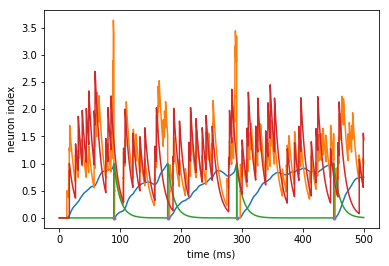

In [7]:
generate_tex_file(net3,'tmp/net7.tex')
create_pdf('tmp/net7.tex','pdf/net7')

In [23]:
G

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_2')

In [52]:
import sympy
a = syn._pathways[0].abstract_code
l = a.split('\n')
l = [x.split('=') for x in l[:-1]] # exclude last element in l, because using split on '\n', the last element in list in empty string

In [46]:
k = '='.join(l[0])
k
sympy.latex(str_to_sympy(a))

'_w = 1.0*w*exp(-0.02*(t - lastupdate)/ms)'

In [48]:
[[print(i) for i in x]   for x in l]

_w 
 1.0*w*exp(-0.02*(t - lastupdate)/ms)
w 
 _w
v +
 w
lastupdate 
 t


[[None, None], [None, None], [None, None], [None, None]]

In [15]:
syn.event_driven

dw/dt = -0.02*w/ms : radian (event-driven)


In [25]:
G1.equations

dv/dt = -0.1*v/ms : radian


In [24]:
print(G1.equations)

dv/dt = -v / (10*ms) : 1


In [2]:
import re
import sympy
import os.path
import subprocess
from graphviz import Digraph
from brian2tools import brian_plot
from matplotlib import pyplot as pp
from brian2.parsing.sympytools import str_to_sympy
from jinja2 import Environment, FileSystemLoader
from brian2.groups.neurongroup import NeuronGroup
from brian2.monitors import SpikeMonitor, StateMonitor, PopulationRateMonitor
from brian2.synapses.synapses import Synapses
import warnings

In [3]:
def replace_underscore(x):
    return '\\texttt{'+  x.replace('_','\\_') + '}'

In [4]:
def generate_ng_latex(NG):
    '''
    NG: NeuronGroup
    
    generate a string containing latex format presentation of input NeuronGroup
    '''
    NG_name = replace_underscore(NG.name)
    text = ['\n\\section{NeuronGroup %s}\n' % (NG_name), r'NeuronGroup "%s" with %d neurons.\\\\' % (NG_name, NG._N)]
    text.append(r'\textbf{Model:} \\ ')
    text.append(sympy.latex(NG.equations))

    def add_event_to_text(event):
        if event=='spike':
            event_header = 'Spiking behaviour'
            event_condition = 'Threshold condition'
            event_code = 'Reset statement(s)'
        else:
            event_header = 'Event "%s"' % event
            event_condition = 'Event Condition'
            event_code = 'Executed Statement(s)'
        condition = NG.events[event]
        text.append('\\textbf{ $ %s $ :}\n\\begin{itemize}' % event_header)
        text.append(r'\item \textit{%s:}' % event_condition)
        text.append('\\begin{lstlisting}\n' + str(condition) + '\n\\end{lstlisting}')
        statements = NG.event_codes.get(event, None)
        if statements is not None:
            text.append(r'\item \textit{%s:}' % event_code)
            #if '\n' in str(statements):
             #   text.append('\\')
            text.append('\\begin{lstlisting}\n' + str(condition) + '\n\\end{lstlisting}')
        text.append('\end{itemize}')

    if 'spike' in NG.events:
        add_event_to_text('spike')
    for event in NG.events:
        if event!='spike':
            add_event_to_text(event)
    text.append('\\')

    return '\n'.join(text)
        

In [5]:
def generate_network_graph(net):
    '''
    net: Network object in brian2
    
    generate a network graph
    '''
    g = Digraph('G', filename='synapse.gv')

    g.attr('node', shape='doublecircle')

    #print collect()
    for obj in net.objects:
        g.attr('node', shape='doublecircle')
        #print(obj.name, obj.__class__.__name__) 
        if obj.__class__ is Synapses:
            g.attr('node', shape='doublecircle')
            #print ('    from=%s to=%s'%(obj.source.name, obj.target.name) )
            g.edge(obj.source.name, obj.target.name, label='<<b><i>'+obj.name+'</i></b>>', nodesep='1',minlen='4' )
        if obj.__class__ is SpikeMonitor:
            g.attr('node', shape='diamond')
            g.edge(obj.name, obj.source.name)
        if obj.__class__ is StateMonitor:
            g.attr('node', shape='pentagon')
            g.edge(obj.name, obj.source.name)

    path = g.render('net', 'tmp', format='png' )
    
    return '{'+path+'}'

In [6]:
def generate_latex_synapse_on_pre(syn):
    '''
    str_on_pre = ''
    for x in syn._pathways:
        eq = re.compile('[+*-]?=')
        comment = re.compile('#.*')

        l = x.code.split('\n')
        l = [x for x in l if x] # remove empty string element in list
        l_eq = [eq.search(x).group() for x in l]
        l = [eq.split(x,1) if eq.search(x) else x for x in l ] # split on equal sign, plus equal etc.
        l_rh = [comment.sub('', x[-1]) for x in l] # remove comment
        l_lh = [x[0] for x in l]
        l_comment = [y.group() if y else '' for y in  [comment.search(x[-1]) for x in l]] #extract a comment list
        
        eq_latex = ''
        for i, _ in enumerate(l_lh):
            eq_latex += sympy.latex(str_to_sympy(l_lh[i])) + '&' + l_eq[i] + sympy.latex(str_to_sympy(l_rh[i])) + '\\text{' + l_comment[i] + '}'
        eq_latex = '\\begin{align}\n' + eq_latex + '\\end{align}\n'
        str_on_pre += eq_latex
        
        return str_on_pre
    '''
    '''
    str_pre_post = ''
    x = syn._pathways[0] # pathways[0] contains on_pre code
    l = x.code.split('\n')
    l = [i.strip() for i in l]
    eqs_on_pre = '\\begin{lstlisting}[language=Python,breaklines,showstringspaces=false]\n' + '\n\n'.join(l) + '\\end{lstlisting}\n'
    str_pre_post = str_pre_post + '\n\\textbf{\\texttt{on\\_pre}}:\n' + eqs_on_pre + '\\bigskip \\textbf{\\texttt{on\\_post}}:\n'
    
    x = syn._pathways[1] # pathways[0] contains on_pre code
    l = x.code.split('\n')
    l = [i.strip() for i in l]
    eqs_on_post = '\\begin{lstlisting}[language=Python,breaklines,showstringspaces=false]\n' + '\n\n'.join(l) + '\\end{lstlisting}\n'
    str_pre_post = str_pre_post + eqs_on_post
   '''

    str_pre_post = ''
    for x in syn._pathways:
        l = x.code.split('\n')
        l = [i.strip() for i in l]
        begin_listing = '\\begin{lstlisting}[language=Python,breaklines,showstringspaces=false]\n'
        eqs = begin_listing + '\n\n'.join(l) + '\\end{lstlisting}\n'
        if x.prepost == 'pre':
            str_pre_post += '\n\\textbf{\\texttt{on\\_pre}}:\n' + replace_underscore(x.name) + eqs
        elif x.prepost == 'post':
            str_pre_post += '\n\\textbf{\\texttt{on\\_post}}:\n'+ replace_underscore(x.name) + eqs
        str_pre_post += '\\bigskip'

    return str_pre_post

In [36]:
def generate_latex_synapse_on_event(syn):
    str_events = []
    if len(S.events)>0:
        str_events.append('\n'+ replace_underscore('on_events') + '\n\\begin{lstlisting}[language=Python,breaklines,showstringspaces=false]\n')
        for k,v in S.events.items():
            str_events.append(k+': ')
            str_events.append(v+'\n')
        str_events.append('\\end{lstlisting}')
    return ''.join(str_events)

In [44]:
def generate_syn_latex(syn):
    '''
    write the Synapses latex code into file.
    '''
    syn_name = '\\section{Synapse' + replace_underscore(syn.name) + '}'
    syn_string = []
    
    syn_string.append(syn_name)  
    syn_string.append('This is a Synapse group with following attributes:\\\\')
    if len(syn.equations) != 0:
        syn_string.append(sympy.latex(syn.equations))
    syn_string.append(generate_latex_synapse_on_pre(syn))
    syn_string.append(generate_latex_synapse_on_event(syn))
    
    return ''.join(syn_string)

In [9]:
def generate_state_mon_latex(mon):
    '''
    write StateMonitor and SpikeMonitor group into file
    '''
    
    if len(mon.record_variables) != 1:
        warnings.warn('''brian_plot only works for a StateMonitor that records a single variable. 
                         So brian_docs will ignore StateMonitors which record more than one variables. 
                         For documentation of those StateMonitors, it is suggested to put those 
                         variables in different StateMonitors, and ensure that each StateMonitor
                         only has one variable''')
        return ''
    else:
        pic_path = 'tmp/' + mon.name + '.png'
        brian_plot(mon)
        pp.savefig(pic_path)
        mon_name = replace_underscore(mon.name)

        return '\n\n\\section{StateMonitor ' + mon_name + '}:\\\\\n\\includegraphics[width=\\textwidth]{'+ pic_path + '}'
    

In [10]:
def generate_spike_mon_latex(mon):
    '''
    write StateMonitor and SpikeMonitor group into file
    '''
    pic_path = 'tmp/' + mon.name + '.png'
    brian_plot(mon)
    pp.savefig(pic_path)
    mon_name = replace_underscore(mon.name)

    return '\n\n\\section{SpikeMonitor ' + mon_name + '}:\\\\\n\\includegraphics[width=\\textwidth]{'+ pic_path + '}'
    

In [11]:
def generate_constant_list(constant_dict):
    if not constant_dict:
        return ['No\\;Constant\\;Is\\;Documented']
    else:
        constant_list = []
        for key, value in d.items():
            if key.count('_')<1:
                key_str = key
            elif key.count('_')==1:
                l = key.split('_')
                key_str = l[0]+'_{' + l[1] + '}'
            else:
                key_str = '\\textit{' + replace_underscore(key)

            if isinstance(value, Quantity):
                constant_list.append(key_str+':'+ value.in_best_unit(python_code=True))
            else:
                constant_list.append(key_str+':'+str(value))

        return constant_list

In [25]:
def generate_tex_file(net, outputFile, constant_dict=None):
    file = open(outputFile,'w')
    net_graph_path = generate_network_graph(net)
    net_graph_latex_path = net_graph_path.replace('\\','/')
    
    net_list=[]
    for obj in net.objects:
        if obj.__class__ is NeuronGroup:
            net_list.append(generate_ng_latex(obj))
        if obj.__class__ is Synapses:
            net_list.append(generate_syn_latex(obj))
        if obj.__class__ is StateMonitor:
            net_list.append(generate_state_mon_latex(obj))
        if obj.__class__ is SpikeMonitor:
            net_list.append(generate_spike_mon_latex(obj))
    if constant_dict != None:
        constant_list = generate_constant_list(constant_dict)
    else:
        constant_list = ['No\\;Constant\\;Is\\;Documented']
    
    file_loader = FileSystemLoader('templates')
    env = Environment(loader=file_loader)
    template = env.get_template('template.txt')
    output = template.render(net_graph_latex_path=net_graph_latex_path, net_list=net_list, constant_list = constant_list)
    
    file.write(output)
    file.close()

In [13]:
def create_pdf(input_filename, output_filename):
    process = subprocess.Popen([
        'latex',   # Or maybe 'C:\\Program Files\\MikTex\\miktex\\bin\\latex.exe
        '-output-format=pdf',
        '-job-name=' + output_filename,
        input_filename])
    process.wait()

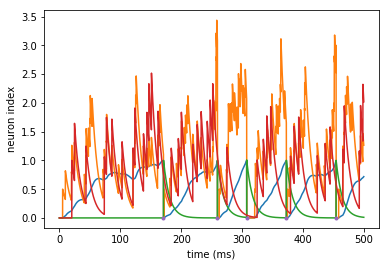

In [45]:
generate_tex_file(net3,'tmp/net4.tex')
create_pdf('tmp/net4.tex','pdf/net4')